In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 1.5 MB/s 
     |████████████████████████████████| 60 kB 4.2 MB/s 
Mounted at /content/drive


In [2]:
import utils
from google.colab.patches import cv2_imshow

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SF_notloaded = True   #set to True after first run once you have your files in the Files folder of Colab 

In [ ]:
# if not SF_notloaded:
#   utils.onceSF()

In [3]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 4.9 MB/s 


In [3]:
import tensorflow as tf
from keras import layers
from keras.callbacks import TensorBoard, LearningRateScheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import efficientnet.keras as efn 
from utils import *
from keras.models import Sequential
from keras import backend as K
from keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Activation, BatchNormalization, multiply
import collections


In [4]:
""" Global variables """
IMG_SIZE = (224,224)
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 40 # 40 classes in the Stanford40 dataset

#utils.onceSF()

""" Load Stanford40 dataset """
#Load the dataset which has already been preprocessed, set needDirectories to False if SF_train, SF_test, and SF_validation dirs already exist
train_ds, test_ds, val_ds, train_labels, test_labels, validation_labels, class_names = utils.loadSF40(img_size =  IMG_SIZE, needDirectories=True)

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
#http://man.hubwiz.com/docset/TensorFlow_2.docset/Contents/Resources/Documents/tf/data/Dataset.html 


Streaming output truncated to the last 5000 lines.
cooking_936.jpg cooking
cooking_937.jpg cooking
cutting_trees_938.jpg cutting_trees
cutting_trees_939.jpg cutting_trees
cutting_trees_940.jpg cutting_trees
cutting_trees_941.jpg cutting_trees
cutting_trees_942.jpg cutting_trees
cutting_trees_943.jpg cutting_trees
cutting_trees_944.jpg cutting_trees
cutting_trees_945.jpg cutting_trees
cutting_trees_946.jpg cutting_trees
cutting_trees_947.jpg cutting_trees
cutting_trees_948.jpg cutting_trees
cutting_trees_949.jpg cutting_trees
cutting_trees_950.jpg cutting_trees
cutting_trees_951.jpg cutting_trees
cutting_trees_952.jpg cutting_trees
cutting_trees_953.jpg cutting_trees
cutting_trees_954.jpg cutting_trees
cutting_trees_955.jpg cutting_trees
cutting_trees_956.jpg cutting_trees
cutting_trees_957.jpg cutting_trees
cutting_trees_958.jpg cutting_trees
cutting_trees_959.jpg cutting_trees
cutting_trees_960.jpg cutting_trees
cutting_trees_961.jpg cutting_trees
cutting_trees_962.jpg cutting_trees
c

In [5]:
""" One-hot encoding """

def onehot_encoding(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#Apply one hot encoding to the different datasets
train_ds = train_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
#train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
#val_ds = val_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(onehot_encoding)
#test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

print("Done one-hot encoding!")


Done one-hot encoding!


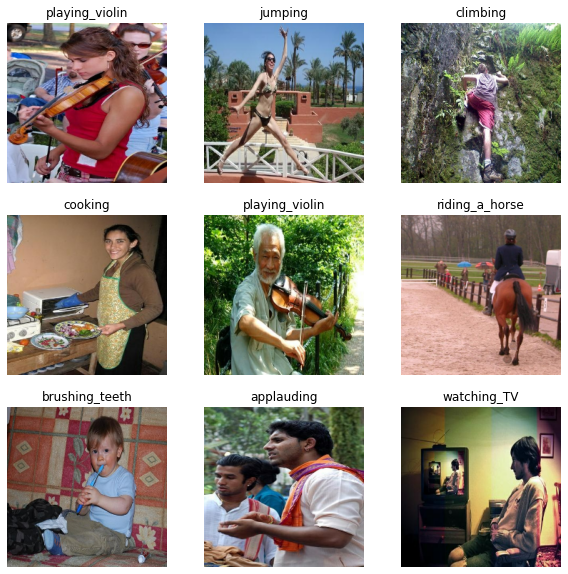

In [6]:
#Visualize Data1
def format_label(label):
    index=[i for i, e in enumerate(label) if e == 1]
    return class_names[index[0]]
    #return string_label.split("-")[1]

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title("{}".format(format_label(label[i])))
    plt.axis("off")

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(40,), dtype=float32)
indexis:  [22]
(224, 224, 3)
pushing_a_cart


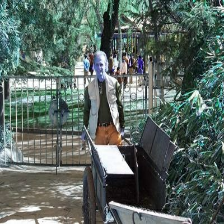

tf.Tensor(
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(40,), dtype=float32)
indexis:  [6]
(224, 224, 3)
cutting_trees


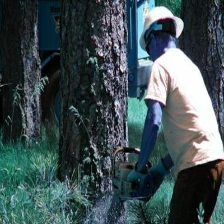

In [61]:
#Visualize data2
import matplotlib.pyplot as plt


for images, labels in train_ds.take(2):
  print(labels[0])
  index=[i for i, e in enumerate(labels[0]) if e == 1]
  print("indexis: ",index)
  print(images[0].shape)
  print(class_names[index[0]])
  cv2_imshow(images[0].numpy().astype("uint8"))

In [7]:
#Baseline model architecture
bl_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Flatten(),                     
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dense(units=40, activation='softmax')
])

In [8]:
bl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [9]:
#Compiling and fitting Maxpool model
bl_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [11]:
#hist = bl_model.fit_generator(steps_per_epoch=3200,generator=train_ds, validation_data= val_ds, validation_steps=10,epochs=100,callbacks=[checkpoint,early])
maxpool_history=bl_model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint,early])

Epoch 1/30
 10/113 [=>............................] - ETA: 1:42:50 - loss: 1094.5400 - accuracy: 0.0500

KeyboardInterrupt: ignored

In [ ]:
""" Build & Train Stanford40 Model EfficientNet"""

# Define the input and output layers of the model 
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

#Fetch image augmentation layers and apply to inputs
img_augmentation = dataAugmentation()
x = img_augmentation(inputs)

outputs = efn.EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x) #Include top set to true as we are not using pre-trained weights but training from scratch


optimizer = tf.keras.optimizers.Adam(learning_rate=tf.Variable(0.01), beta_1=tf.Variable(0.9), beta_2=tf.Variable(0.999), epsilon=tf.Variable(1e-7),)
optimizer.iterations
optimizer.decay = tf.Variable(0.0)

# Initialise the model. Compule and show summary. 
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


#Fit the model with the data augmentation and normalisation iterators    ### , steps_per_epoch = NO_TRAIN_IMGS//BATCH_SIZE ## validation_steps=NO_VAL_IMGS//BATCH_SIZE, 
history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, verbose=2)

#Save weights and model as we need these for transfer learning 
model.save_weights("model_weights", save_format='tf')
tf.keras.models.save_model(model, "SF_model", include_optimizer=True, save_format='tf')



#Plot loss and accuracy
plotAccuracy("Accuracy on Stanford 40", history.history['accuracy'], history.history['val_accuracy'])                     # made these plotting functions in utils for hassle-free plotting
plotLoss("Accuracy on Stanford 40", history.history['loss'], history.history['val_loss'])



AttributeError: ignored

In [ ]:
tf.keras.models.save_model(model, "NoOptimiser", include_optimizer=False, save_format='tf')

INFO:tensorflow:Assets written to: NoOptimiser/assets


In [ ]:
#Zip and download the model
!zip -r /content/SF_model.zip /content/SF_model
from google.colab import files
files.download("SF_model.zip")

  adding: content/SF_model/ (stored 0%)
  adding: content/SF_model/keras_metadata.pb (deflated 96%)
  adding: content/SF_model/saved_model.pb (deflated 91%)
  adding: content/SF_model/variables/ (stored 0%)
  adding: content/SF_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/SF_model/variables/variables.index (deflated 74%)
  adding: content/SF_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Zip and download the model
!zip -r /content/NoOptimiser.zip /content/NoOptimiser
from google.colab import files
files.download("NoOptimiser.zip")

  adding: content/NoOptimiser/ (stored 0%)
  adding: content/NoOptimiser/keras_metadata.pb (deflated 96%)
  adding: content/NoOptimiser/saved_model.pb (deflated 91%)
  adding: content/NoOptimiser/variables/ (stored 0%)
  adding: content/NoOptimiser/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/NoOptimiser/variables/variables.index (deflated 74%)
  adding: content/NoOptimiser/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
""" Tutorials used to build model"""
#https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
#https://towardsdatascience.com/an-in-depth-efficientnet-tutorial-using-tensorflow-how-to-use-efficientnet-on-a-custom-dataset-1cab0997f65c
#https://www.kaggle.com/code/arjunrao2000/beginners-guide-efficientnet-with-keras/notebook

""" Cyclical learning rate example"""
#https://pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/